# Mask R-CNN for FashionAi key point location

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import utils
import model as modellib
import visualize
from model import log
from config import Config
from Clothes_train import FIDataset
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
class InferenceConfig(Config):
  # Give the configuration a recognizable name
    NAME = "FI"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_KEYPOINTS = 24
    KEYPOINT_MASK_SHAPE = [56, 56]
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 24 key_point

    RPN_TRAIN_ANCHORS_PER_IMAGE = 150
    VALIDATION_STPES = 100
    STEPS_PER_EPOCH = 100
    MINI_MASK_SHAPE = (56, 56)
    KEYPOINT_MASK_POOL_SIZE = 7
            # Pooled ROIs
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    WEIGHT_LOSS = True
    KEYPOINT_THRESHOLD = 0.005
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 128

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
model_path = os.path.join(ROOT_DIR, "logs/tf0401/mask_rcnn_fi_0080.h5")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/shenhuaifeng/Documents/Mask_RCNN_FashionAI-master/logs/tf0401/mask_rcnn_fi_0080.h5


## Dataset

In [3]:
# Load dataset
assert inference_config.NAME == "FI"
# Training dataset
#load clothing keypoints dataset
# Training dataset
dataset_train = FIDataset()
dataset_train.load_FI(category='train')
dataset_train.prepare()

# Validation dataset
dataset_val = FIDataset()
dataset_val.load_FI(category='val')
dataset_val.prepare()

loading image:0/59
loading image:1/59
loading image:2/59
loading image:3/59
loading image:4/59
loading image:5/59
loading image:6/59
loading image:7/59
loading image:8/59
loading image:9/59
loading image:10/59
loading image:11/59
loading image:12/59
loading image:13/59
loading image:14/59
loading image:15/59
loading image:16/59
loading image:17/59
loading image:18/59
loading image:19/59
loading image:20/59
loading image:21/59
loading image:22/59
loading image:23/59
loading image:24/59
loading image:25/59
loading image:26/59
loading image:27/59
loading image:28/59
loading image:29/59
loading image:30/59
loading image:31/59
loading image:32/59
loading image:33/59
loading image:34/59
loading image:35/59
loading image:36/59
loading image:37/59
loading image:38/59
loading image:39/59
loading image:40/59
loading image:41/59
loading image:42/59
loading image:43/59
loading image:44/59
loading image:45/59
loading image:46/59
loading image:47/59
loading image:48/59
loading image:49/59
loading im

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (1, 4)                min:  172.00000  max:  322.00000
gt_keypoint              shape: (1, 24, 3)            min:    0.00000  max:  321.00000
There are 4  keypoints in pic!


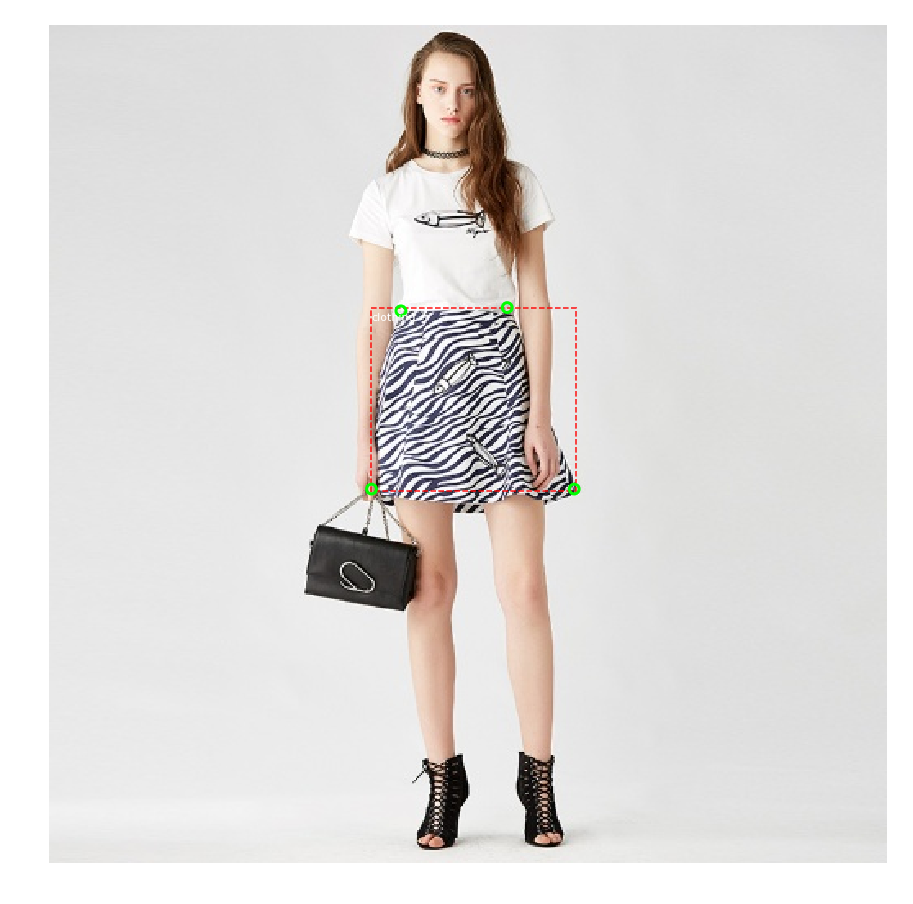

In [4]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_keypoint =\
    modellib.load_image_gt_keypoints(dataset_val, inference_config, 
                           image_id, augment=False,use_mini_mask=inference_config.USE_MINI_MASK)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_keypoint", gt_keypoint)
visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,dataset_val.class_names)

## Dataset

rois                     shape: (1, 4)                min:  171.00000  max:  314.00000
keypoints                shape: (1, 24, 3)            min:    1.00000  max:  306.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
keypoints                shape: (1, 24, 3)            min:    1.00000  max:  306.00000
There are 24  keypoints in pic!


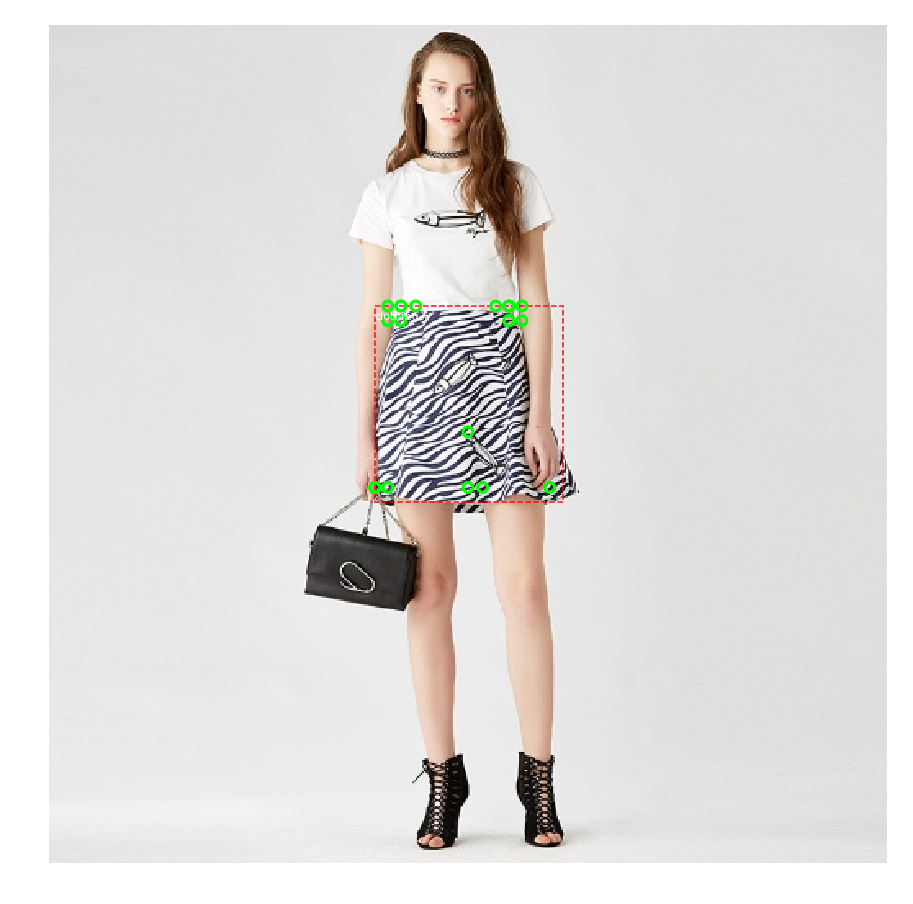

In [5]:
results = model.detect_keypoint([original_image], verbose=0)

r = results[0] # for one image

log("rois",r['rois'])
log("keypoints",r['keypoints'])
log("class_ids",r['class_ids'])
log("keypoints",r['keypoints'])

visualize.display_keypoints(original_image,r['rois'],r['keypoints'],r['class_ids'],dataset_val.class_names)